<a href="https://colab.research.google.com/github/sadekovlar/3D_Detection/blob/main/omni3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Развертывание Omni3D (Cube R-CNN)**
Документация: https://github.com/facebookresearch/omni3d </br>

Omni3D — это крупномасштабный бенчмарк и модель для задачи 3D-детекции объектов в условиях реального мира. В отличие от датасетов, ограниченных конкретной средой (например, только интерьеры или автономное вождение), Omni3D объединяет и стандартизирует несколько существующих датасетов (KITTI, nuScenes, SUN RGB-D, Objectron и др.) в единую, согласованную систему аннотаций. Такой подход позволяет обучать и оценивать модели на разнообразных сценах (улица, дом, офис) с единой системой координат и метриками.

## **Проверка среды и подготовка**

In [ ]:
# Проверяем версии ПО по умолчанию в Colab (для справки)
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Вывод информации о GPU
!nvidia-smi

PyTorch version: 2.9.0+cu126
CUDA version: 12.6
CUDA available: True


## **Создание виртуального окружения**

Используем python3.8 явно, так как версия Python в Colab по умолчанию может быть новее.

In [ ]:
# Очищаем старое окружение (если было)
!rm -rf /content/cubercnn_env

# Обновляем пакетный менеджер и устанавливаем Python 3.8
!apt-get update -q
!apt-get install -y python3.8 python3.8-venv python3.8-dev

# Создаем виртуальное окружение с Python 3.8
!python3.8 -m venv /content/cubercnn_env
!/content/cubercnn_env/bin/python -m pip install -U pip setuptools wheel
!/content/cubercnn_env/bin/python -c "import sys; print(sys.version)"


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,228 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://cli.github.com/packages stable/main amd64 Packages [345 B]
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,580 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restri

## **Установка необходимых пакетов**

In [ ]:
# Устанавливаем совместимые версии PyTorch, torchvision и torchaudio для CUDA 11.8
!/content/cubercnn_env/bin/pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 \
  --index-url https://download.pytorch.org/whl/cu118

!/content/cubercnn_env/bin/python -c "import torch; print(torch.__version__, torch.version.cuda)"

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 121.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 61.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of typing-extensions to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 161.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 140.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 26.8 MB/s eta 0:00:00
2.1.0+cu118 11.8


In [ ]:
# Принудительно устанавливаем NumPy версии ниже 2.0.0 и другие базовые пакеты

!/content/cubercnn_env/bin/pip install matplotlib-inline
!/content/cubercnn_env/bin/pip install ipython
!/content/cubercnn_env/bin/pip install "numpy<2" fvcore iopath

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 72.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.0/806.0 kB 30.2 MB/s eta 0:00:00
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61398 sha256=281d52c54b537a884579e07af37b9e01c7c417d7da84d5b7c32c812fee84ce51
  Stored in directory: /root/.cache/pip/wheels/b8/79/07/c0e9367f5b5ea325e246bd73651e8af175fabbef943043b1cc
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=713363962b0f8a89f2925b4ca70a40641b6f30ce6de0845b95909419605656a4
  Stored in directory: /root/.cache/pip/wheels/89/3e/24/0f349c0b2eeb6965903035f3b00dbb5c9bea437b4a2f18d82c
Successfully built fvcore iopath


In [ ]:
# Проверяем версии
!/content/cubercnn_env/bin/python -c "import torch, numpy as np; print('torch', torch.__version__); print('numpy', np.__version__); print('cuda', torch.version.cuda)"

torch 2.1.0+cu118
numpy 1.24.4
cuda 11.8


In [ ]:
!/content/cubercnn_env/bin/pip install cython ninja scipy matplotlib seaborn opencv-python tqdm yacs termcolor tabulate cloudpickle

 # Устанавливаем fvcore и iopath (критически важны для Detectron2)
!/content/cubercnn_env/bin/pip install 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/facebookresearch/iopath.git'

# Устанавливаем COCO API для работы с аннотациями
!/content/cubercnn_env/bin/pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 171.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 149.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 200.0 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-_q01gu_a
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-_q01gu_a
  Resolved https://github.com/facebookresearch/fvcore.git to commit 70e69fb3ff7a82631f6a82061a7650c4f11da876
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/iopath.git to /tmp/pip-req-build-h8mm

Установим CUDA Toolkit 11.8 — специальный набор инструментов NVIDIA для работы с видеокартой. Без него не будут работать ключевые компоненты Omni3D: библиотеки Detectron2 и PyTorch3D не смогут скомпилировать свои GPU-ускорители, так как им нужен компилятор nvcc именно из CUDA 11.8. Colab по умолчанию часто имеет более новую версию CUDA, что вызывает конфликты. Устанавливая конкретно 11.8, мы гарантируем полную совместимость с версией PyTorch, которую будем использовать, и даём системе правильные инструменты для сборки остальных зависимостей проекта.

In [ ]:
# Установка занимает минут 10
!wget -q https://developer.download.nvidia.com/compute/cuda/11.8.0/local_installers/cuda_11.8.0_520.61.05_linux.run
!sudo sh cuda_11.8.0_520.61.05_linux.run --toolkit --silent --override

!/usr/local/cuda-11.8/bin/nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


### Установка и сборка Detectron2

In [ ]:
#Примерно 3-5 минут
!sudo apt-get update -q
!sudo apt-get install -y build-essential ninja-build cmake

# Удаляем старые версии detectron2, если они были
!/content/cubercnn_env/bin/pip uninstall -y detectron2
!rm -rf /tmp/pip-req-build-*

# Клонируем и устанавливаем detectron2 с правильными путями к CUDA
!env CUDA_HOME=/usr/local/cuda-11.8 PATH=/usr/local/cuda-11.8/bin:$PATH \
  /content/cubercnn_env/bin/pip install --no-build-isolation --no-cache-dir -v \
  "git+https://github.com/facebookresearch/detectron2.git"

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lis

Флаг `--no-build-isolation` и явное указание CUDA_HOME критически важны. Они гарантируют, что процесс сборки использует нашу версию CUDA 11.8, а не системную. Без этого могут возникнуть ошибки.

In [ ]:
# Проверяем установку
!/content/cubercnn_env/bin/python -c "import detectron2; import torch; print('ok', torch.__version__, torch.version.cuda)"

ok 2.1.0+cu118 11.8


### Установка и сборка PyTorch3D (Самый долгий этап)
Этот шаг может занять до 30 минут, так как компилируется множество C++/CUDA расширений. Флаг -v (verbose) позволит видеть прогресс. Если процесс завис на несколько минут — это нормально.

In [ ]:
# Установка минут 30
!rm -rf /content/pytorch3d
!git clone https://github.com/facebookresearch/pytorch3d.git /content/pytorch3d

!env CUDA_HOME=/usr/local/cuda-11.8 PATH=/usr/local/cuda-11.8/bin:$PATH \
  /content/cubercnn_env/bin/pip install --no-build-isolation -v -e /content/pytorch3d


Cloning into '/content/pytorch3d'...
remote: Enumerating objects: 15154, done.
remote: Counting objects: 100% (2681/2681), done.
remote: Compressing objects: 100% (370/370), done.
remote: Total 15154 (delta 2432), reused 2311 (delta 2311), pack-reused 12473 (from 3)
Receiving objects: 100% (15154/15154), 49.45 MiB | 32.17 MiB/s, done.
Resolving deltas: 100% (10619/10619), done.
Using pip 25.0.1 from /content/cubercnn_env/lib/python3.8/site-packages/pip (python 3.8)
Obtaining file:///content/pytorch3d
  Running command python setup.py egg_info
  running egg_info
  creating /tmp/pip-pip-egg-info-8o3soxcd/pytorch3d.egg-info
  writing /tmp/pip-pip-egg-info-8o3soxcd/pytorch3d.egg-info/PKG-INFO
  writing dependency_links to /tmp/pip-pip-egg-info-8o3soxcd/pytorch3d.egg-info/dependency_links.txt
  writing entry points to /tmp/pip-pip-egg-info-8o3soxcd/pytorch3d.egg-info/entry_points.txt
  writing requirements to /tmp/pip-pip-egg-info-8o3soxcd/pytorch3d.egg-info/requires.txt
  writing top-level

In [ ]:
# Проверяем установку
!/content/cubercnn_env/bin/python -c "import pytorch3d; print('pytorch3d ok')"

pytorch3d ok


## **DEMO**

In [ ]:
# Клонируем репозиторий Omni3D
%cd /content
!git clone https://github.com/facebookresearch/omni3d.git
%cd /content/omni3d
!ls

/content
Cloning into 'omni3d'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 232 (delta 38), reused 34 (delta 34), pack-reused 178 (from 1)
Receiving objects: 100% (232/232), 6.92 MiB | 13.68 MiB/s, done.
Resolving deltas: 100% (103/103), done.
/content/omni3d
configs   DATA.md   demo	MODEL_ZOO.md  RESULTS.md
cubercnn  datasets  LICENSE.md	README.md     tools


In [ ]:
# Скачиваем примеры изображений для демонстрации
!sh demo/download_demo_COCO_images.sh

Скачиваем примеры изображений COCO...
--2026-01-07 19:06:09--  https://farm1.staticflickr.com/19/3045175664_6e42bd43f3_z.jpg
Resolving farm1.staticflickr.com (farm1.staticflickr.com)... 18.155.176.82, 2600:9000:2366:9800:0:5a51:64c9:c681, 2600:9000:2366:6200:0:5a51:64c9:c681, ...
Connecting to farm1.staticflickr.com (farm1.staticflickr.com)|18.155.176.82|:443... connected.
HTTP request sent, awaiting response... 429 Too Many Requests
2026-01-07 19:06:09 ERROR 429: Too Many Requests.

--2026-01-07 19:06:09--  https://farm1.staticflickr.com/19/6140190660_c220e6e1ea_z.jpg
Resolving farm1.staticflickr.com (farm1.staticflickr.com)... 18.155.176.82, 2600:9000:2366:9800:0:5a51:64c9:c681, 2600:9000:2366:6200:0:5a51:64c9:c681, ...
Connecting to farm1.staticflickr.com (farm1.staticflickr.com)|18.155.176.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘6140190660_c220e6e1ea_z.jpg’

6140190660_c220e6e1     [ <=>                ] 101.

Данная последовательность команд выполняет конфигурацию системных путей для Команда echo создаёт конфигурационный файл /etc/ld.so.conf.d/cuda-11-8.conf, в который записываются пути к директориям с библиотеками CUDA 11.8. Это необходимо для того, чтобы динамический загрузчик операционной системы знал, где искать разделяемые библиотеки (например, libcudart.so.11.8), требуемые для работы скомпилированных компонентов PyTorch, Detectron2 и PyTorch3D. Без данной настройки при запуске кода, зависящего от CUDA, возникнет ошибка отсутствия разделяемых библиотек.


In [ ]:
!echo "/usr/local/cuda-11.8/lib64" | sudo tee /etc/ld.so.conf.d/cuda-11-8.conf
!echo "/usr/local/cuda-11.8/targets/x86_64-linux/lib" | sudo tee -a /etc/ld.so.conf.d/cuda-11-8.conf
!sudo ldconfig

/usr/local/cuda-11.8/lib64
/usr/local/cuda-11.8/targets/x86_64-linux/lib
/sbin/ldconfig.real: /usr/local/lib/libtcm.so.1 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_adapter_level_zero.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_adapter_level_zero_v2.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libhwloc.so.15 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libumf.so.1 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_loader.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtcm_debug.so.1 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is

Команда `ldconfig -p | grep nvrtc` выполняет проверку успешности конфигурации, выводя список найденных библиотек, связанных с NVIDIA Runtime Compilation. Положительный результат этой проверки является подтверждением того, что системное окружение корректно настроено для выполнения GPU-зависимого кода.

In [ ]:
!ldconfig -p | grep nvrtc | head -n 50

	libnvrtc.so.12 (libc6,x86-64) => /usr/local/cuda-12/targets/x86_64-linux/lib/libnvrtc.so.12
	libnvrtc.so.11.2 (libc6,x86-64) => /usr/local/cuda/targets/x86_64-linux/lib/libnvrtc.so.11.2
	libnvrtc.so (libc6,x86-64) => /usr/local/cuda/targets/x86_64-linux/lib/libnvrtc.so
	libnvrtc.so (libc6,x86-64) => /usr/local/cuda-12/targets/x86_64-linux/lib/libnvrtc.so
	libnvrtc-builtins.so.12.5 (libc6,x86-64) => /usr/local/cuda-12/targets/x86_64-linux/lib/libnvrtc-builtins.so.12.5
	libnvrtc-builtins.so.11.8 (libc6,x86-64) => /usr/local/cuda/targets/x86_64-linux/lib/libnvrtc-builtins.so.11.8
	libnvrtc-builtins.so (libc6,x86-64) => /usr/local/cuda/targets/x86_64-linux/lib/libnvrtc-builtins.so
	libnvrtc-builtins.so (libc6,x86-64) => /usr/local/cuda-12/targets/x86_64-linux/lib/libnvrtc-builtins.so


In [ ]:
# Запускаем демо-скрипт с предобученной моделью DLA34
print("\nЗапускаем демо Omni3D...")
!/content/cubercnn_env/bin/python demo/demo.py \
    --config-file cubercnn://omni3d/cubercnn_DLA34_FPN.yaml \
    --input-folder "datasets/coco_examples" \
    --threshold 0.25 \
    MODEL.WEIGHTS cubercnn://omni3d/cubercnn_DLA34_FPN.pth \
    OUTPUT_DIR output/demo


Запускаем демо Omni3D...
Command Line Args: Namespace(config_file='cubercnn://omni3d/cubercnn_DLA34_FPN.yaml', display=False, dist_url='tcp://127.0.0.1:49152', eval_only=True, focal_length=0, input_folder='datasets/coco_examples', machine_rank=0, num_gpus=1, num_machines=1, opts=['MODEL.WEIGHTS', 'cubercnn://omni3d/cubercnn_DLA34_FPN.pth', 'OUTPUT_DIR', 'output/demo'], principal_point=[], threshold=0.25)
[01/07 20:51:13 detectron2]: Rank of current process: 0. World size: 1
[01/07 20:51:13 detectron2]: Environment info:
-------------------------------  ---------------------------------------------------------------------------
sys.platform                     linux
Python                           3.8.20 (default, Sep  7 2024, 18:35:08) [GCC 11.4.0]
numpy                            1.24.4
detectron2                       0.6 @/content/cubercnn_env/lib/python3.8/site-packages/detectron2
Compiler                         GCC 11.4
CUDA compiler                    CUDA 11.8
detectron2 arch

Found 16 rendered images


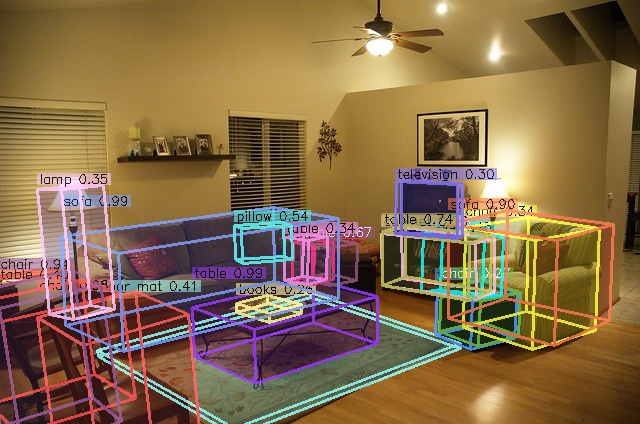

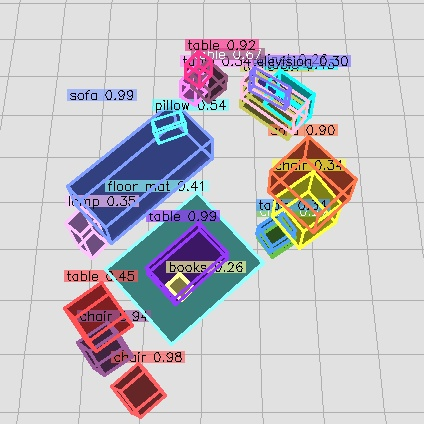

In [ ]:
#Просмотр полученных изображений

from IPython.display import Image, display
import glob

paths = sorted(glob.glob("/content/omni3d/output/demo/**/*.png", recursive=True) +
               glob.glob("/content/omni3d/output/demo/**/*.jpg", recursive=True))
print("Found", len(paths), "rendered images")

for p in paths[:2]:
    display(Image(filename=p))


После запуска скрипта с указанными параметрами:
*   Выполняется загрузка весов предобученной модели Cube R-CNN (DLA34) и её конфигурации, если они отсутствуют в локальном кэше.
*   Затем модель последовательно обрабатывает изображения из указанной входной директории (datasets/coco_examples). Для каждого изображения выполняется 3D-детекция: модель предсказывает классы объектов, их двумерные ограничивающие рамки (bbox), глубину (depth) и трёхмерные ограничивающие параллелепипеды (3D cuboids) в координатах сцены.
*   Все итоговые изображения и данные сохраняются в директории, указанной параметром OUTPUT_DIR (output/demo).
<br> Пример изображений в папке output:
<br> 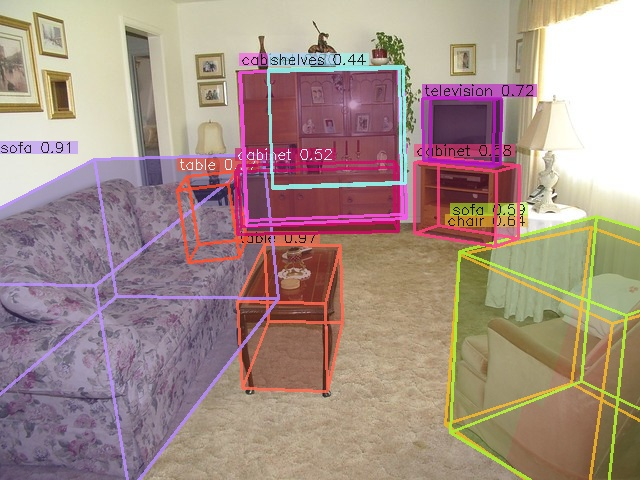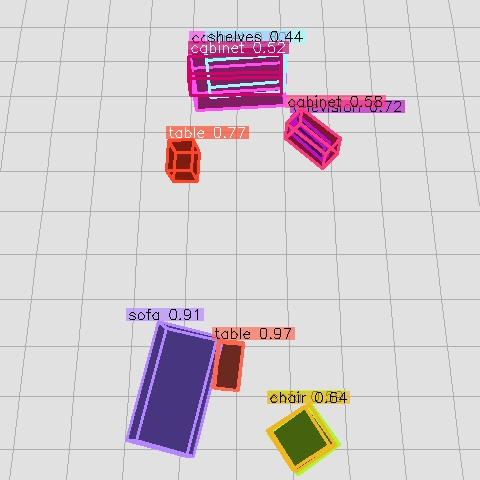



*   Первое изображение - исходное RGB‑изображение с наложенными результатами детекции: подписи класса и проекция предсказанного 3D кубоида (ориентация/размер/положение) в плоскость изображения.
*   Второе - схема “вид сверху” на сцену, где те же предсказанные 3D объекты отображаются на плоскости (раскладка по положению в пространстве относительно камеры), что позволяет оценить взаимное расположение объектов по глубине и в боковом направлении.



## ТЕСТ

In [ ]:
%cd /content
!mkdir -p test_videos
# сюда загрузить three1.avi, three2.avi, three3.avi


/content


In [22]:
import cv2, os, glob

video_dir = "/content/test_videos"
frames_dir = "/content/omni3d/datasets/my_video_frames"
os.makedirs(frames_dir, exist_ok=True)

vid_paths = sorted(glob.glob(os.path.join(video_dir, "*.avi")))
print("Videos:", vid_paths)

for vp in vid_paths:
    cap = cv2.VideoCapture(vp)
    base = os.path.splitext(os.path.basename(vp))[0]
    i = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imwrite(os.path.join(frames_dir, f"{base}_frame_{i:06d}.jpg"), frame)
        i += 1
    cap.release()
    print(base, "->", i, "frames")


Videos: ['/content/test_videos/ge5.019.079.left.avi', '/content/test_videos/ge5.019.080.left.avi', '/content/test_videos/ge5.019.092.left.avi', '/content/test_videos/ge5.019.101.left.avi']
ge5.019.079.left -> 80 frames
ge5.019.080.left -> 81 frames
ge5.019.092.left -> 81 frames
ge5.019.101.left -> 79 frames


In [23]:
%cd /content/omni3d
!/content/cubercnn_env/bin/python demo/demo.py \
  --config-file cubercnn://omni3d/cubercnn_DLA34_FPN.yaml \
  --input-folder "datasets/my_video_frames" \
  --threshold 0.25 \
  MODEL.WEIGHTS cubercnn://omni3d/cubercnn_DLA34_FPN.pth \
  OUTPUT_DIR output/demo_my_videos


/content/omni3d
Command Line Args: Namespace(config_file='cubercnn://omni3d/cubercnn_DLA34_FPN.yaml', display=False, dist_url='tcp://127.0.0.1:49152', eval_only=True, focal_length=0, input_folder='datasets/my_video_frames', machine_rank=0, num_gpus=1, num_machines=1, opts=['MODEL.WEIGHTS', 'cubercnn://omni3d/cubercnn_DLA34_FPN.pth', 'OUTPUT_DIR', 'output/demo_my_videos'], principal_point=[], threshold=0.25)
[01/08 15:59:12 detectron2]: Rank of current process: 0. World size: 1
[01/08 15:59:13 detectron2]: Environment info:
-------------------------------  ---------------------------------------------------------------------------
sys.platform                     linux
Python                           3.8.20 (default, Sep  7 2024, 18:35:08) [GCC 11.4.0]
numpy                            1.24.4
detectron2                       0.6 @/content/cubercnn_env/lib/python3.8/site-packages/detectron2
Compiler                         GCC 11.4
CUDA compiler                    CUDA 11.8
detectron2 ar

In [24]:
import cv2, glob, os
from natsort import natsorted

in_dir = "/content/omni3d/output/demo_my_videos"
fps = 25  # подставить реальный FPS исходных видео

# Найти все кадры
all_frames = natsorted(
    glob.glob(os.path.join(in_dir, "*.jpg")) +
    glob.glob(os.path.join(in_dir, "*.png"))
)
print("Total frames:", len(all_frames))

if not all_frames:
    print("No frames found! Check output/demo_my_videos")
else:
    # Группировка по префиксу (например three1_frame_XXXX.jpg)
    frame_groups = {}
    for f in all_frames:
        base_name = os.path.splitext(os.path.basename(f))[0].split("_frame_")[0]
        if base_name not in frame_groups:
            frame_groups[base_name] = []
        frame_groups[base_name].append(f)

    print("Groups:", frame_groups.keys())

    # Сборка каждого видео
    for base, frames in frame_groups.items():
        print(f"\nProcessing {base}: {len(frames)} frames")

        if frames:
            img = cv2.imread(frames[0])
            h, w = img.shape[:2]
            out_path = f"/content/{base}_omni3d_result.avi"

            out = cv2.VideoWriter(
                out_path,
                cv2.VideoWriter_fourcc(*"XVID"),
                fps,
                (w, h)
            )
            for f in frames:
                out.write(cv2.imread(f))
            out.release()
            print(f"Saved: {out_path}")


Total frames: 642
Groups: dict_keys(['ge5.019.079.left', 'ge5.019.080.left', 'ge5.019.092.left', 'ge5.019.101.left'])

Processing ge5.019.079.left: 160 frames
Saved: /content/ge5.019.079.left_omni3d_result.avi

Processing ge5.019.080.left: 162 frames
Saved: /content/ge5.019.080.left_omni3d_result.avi

Processing ge5.019.092.left: 162 frames
Saved: /content/ge5.019.092.left_omni3d_result.avi

Processing ge5.019.101.left: 158 frames
Saved: /content/ge5.019.101.left_omni3d_result.avi
